In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path='.'

In [3]:
scaled_Qdata = pd.read_csv(f'{path}/scaled_QdataKn25width100microns.csv', header=0, index_col=0)  #qdata with Knudsen
print(scaled_Qdata.shape)
scaled_Qdata.head()

(37893, 128)


,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,...,n_18,n_19,n_20,n_21,n_22,n_23,n_24,Qimpact_c-1,Qimpact_c,Qimpact_c+1
0.015007,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,...,-0.473566,-0.473499,-0.473434,-0.473370,-0.473307,-0.473245,-0.473183,-0.947462,-0.944002,-0.940539
0.015011,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,...,-0.473565,-0.473499,-0.473433,-0.473369,-0.473306,-0.473244,-0.473182,-0.947421,-0.943961,-0.940498
0.015016,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,...,-0.473565,-0.473498,-0.473433,-0.473369,-0.473305,-0.473243,-0.473181,-0.947380,-0.943921,-0.940458
0.015021,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,...,-0.473564,-0.473497,-0.473432,-0.473368,-0.473305,-0.473242,-0.473181,-0.947340,-0.943880,-0.940417
0.015026,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,-0.488663,...,-0.473563,-0.473496,-0.473431,-0.473367,-0.473304,-0.473242,-0.473180,-0.947299,-0.943839,-0.940376


In [4]:
validationsize = int(0.2*scaled_Qdata.shape[0]) # 20% of samples for validation
testsize = int(0.2*scaled_Qdata.shape[0]) # 20% of samples for test

In [5]:
shuffled_Qdata=scaled_Qdata.sample(n=scaled_Qdata.shape[0])

validation_data=shuffled_Qdata.iloc[:validationsize]
test_data=scaled_Qdata # All data (not randomized) is kept for visualization of model
train_data=shuffled_Qdata.iloc[validationsize+testsize:]

print('Training dataset size: ', train_data.shape, '\nTesting dataset size: ',test_data.shape,'\nValidation dataset size: ', validation_data.shape)

Training dataset size:  (22737, 128) 
Testing dataset size:  (37893, 128) 
Validation dataset size:  (7578, 128)


In [6]:
threePoint = False
if (threePoint):
    target_fields = ['Qimpact_c-1','Qimpact_c','Qimpact_c+1']
else:
    target_fields = ['Qimpact_c']
drop_fields = ['Qimpact_c-1','Qimpact_c','Qimpact_c+1']

train_features, train_targets = train_data.drop(drop_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(drop_fields, axis=1), test_data[target_fields]
validation_features, validation_targets = validation_data.drop(drop_fields, axis=1), validation_data[target_fields]

In [7]:
l_rate = 0.05
mse_loss = nn.MSELoss(reduction = 'mean')

In [8]:
Nfeatures = train_features.shape[1]
Nfields = 5 # 4 # if Kn dropped
Npoints = Nfeatures / Nfields
print(f'Number of points per field {Npoints}')

Number of points per field 25.0


In [9]:
class Regression(pl.LightningModule):
    
### The Model ### 

    # Question: what will your model architecture look like?
    # Initialize the layers
    # Here we have one input layer (size 56 #3N as we have 56 #3N features), one hidden layer (size 10), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self):
        super(Regression, self).__init__()
        N1 = 20
        N2 = 10
        self.fc1 = nn.Linear(Nfeatures, N1)
        self.fc2 = nn.Linear(N1, N2)
        if (threePoint):
            self.fc3 = nn.Linear(N2, 3)
        else:
            self.fc3 = nn.Linear(N2, 1)            

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Data loader ### 
    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[target_fields].values).float())
        train_loader = DataLoader(dataset = train_dataset, batch_size = 128)
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(),\
                                           torch.tensor(validation_targets[target_fields].values).float())
        validation_loader = DataLoader(dataset = validation_dataset, batch_size = 128)
        return validation_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[target_fields].values).float())
        test_loader = DataLoader(dataset = test_dataset, batch_size = 128)
        return test_loader

### The Optimizer ### 
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=l_rate)

### Training ### 
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ### 
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        correct = torch.sum(logits == y.data)
        
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [10]:
model = Regression()
trainer = Trainer(max_epochs = 100)  # Option to check if it's working at all: fast_dev_run=True 
                                    # Option to implement early stopping: early_stop_callback=True
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 2.5 K 
1 | fc2  | Linear | 210   
2 | fc3  | Linear | 11    
--------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  75%|██████████████████▋      | 178/238 [00:01<00:00, 159.67it/s, loss=0.105, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 1:  75%|█████████████████▉      | 178/238 [00:01<00:00, 162.16it/s, loss=0.0454, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 1:  81%|███████████████████▍    | 193/238 [00:01<00:00, 164.96it/s, loss=0.0454, v_num=52]


Epoch 2:  75%|█████████████████▉      | 178/238 [00:01<00:00, 161.74it/s, loss=0.0305, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 2:  89%|█████████████████████▎  | 211/238 [00:01<00:00, 171.38it/s, loss=0.0305, v_num=52]


Epoch 3:  75%|█████████████████▉      | 178/238 [00:01<00:00, 167.30it/s, loss=0.0225, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 3:  96%|███████████████████████ | 229/238 [00:01<00:00, 181.44it/s, loss=0.0225, v_num=52]


Epoch 4:  75%|██████████████████▋      | 178/238 [00:01<00:00, 166.38it/s, loss=0.018, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 5:  75%|█████████████████▉      | 178/238 [00:01<00:00, 167.67it/s, loss=0.0149, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 5:  77%|██████████████████▌     | 184/238 [00:01<00:00, 169.05it/s, loss=0.0149, v_num=52]


Epoch 6:  75%|█████████████████▉      | 178/238 [00:01<00:00, 168.64it/s, loss=0.0124, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 6:  85%|████████████████████▎   | 202/238 [00:01<00:00, 175.38it/s, loss=0.0124, v_num=52]


Epoch 7:  75%|█████████████████▏     | 178/238 [00:01<00:00, 169.13it/s, loss=0.00989, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 7:  92%|█████████████████████▎ | 220/238 [00:01<00:00, 180.03it/s, loss=0.00989, v_num=52]


Epoch 8:  75%|█████████████████▏     | 178/238 [00:01<00:00, 171.42it/s, loss=0.00847, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████| 238/238 [00:01<00:00, 186.17it/s, loss=0.00847, v_num=52]


Epoch 9:  75%|█████████████████▏     | 178/238 [00:01<00:00, 161.86it/s, loss=0.00724, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 10:  75%|████████████████▍     | 178/238 [00:01<00:00, 169.40it/s, loss=0.00906, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 10:  81%|█████████████████▊    | 193/238 [00:01<00:00, 173.06it/s, loss=0.00906, v_num=52]


Epoch 11:  75%|████████████████▍     | 178/238 [00:01<00:00, 170.81it/s, loss=0.00621, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 11:  89%|███████████████████▌  | 211/238 [00:01<00:00, 179.11it/s, loss=0.00621, v_num=52]


Epoch 12:  75%|████████████████▍     | 178/238 [00:01<00:00, 167.47it/s, loss=0.00458, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 12:  96%|█████████████████████▏| 229/238 [00:01<00:00, 179.06it/s, loss=0.00458, v_num=52]


Epoch 13:  75%|████████████████▍     | 178/238 [00:01<00:00, 167.44it/s, loss=0.00507, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 14:  75%|████████████████▍     | 178/238 [00:01<00:00, 168.99it/s, loss=0.00787, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 14:  77%|█████████████████     | 184/238 [00:01<00:00, 170.13it/s, loss=0.00787, v_num=52]


Epoch 15:  75%|████████████████▍     | 178/238 [00:01<00:00, 166.54it/s, loss=0.00659, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 15:  85%|██████████████████▋   | 202/238 [00:01<00:00, 172.97it/s, loss=0.00659, v_num=52]


Epoch 16:  75%|████████████████▍     | 178/238 [00:01<00:00, 168.01it/s, loss=0.00609, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 16:  92%|████████████████████▎ | 220/238 [00:01<00:00, 182.45it/s, loss=0.00609, v_num=52]


Epoch 17:  75%|████████████████▍     | 178/238 [00:01<00:00, 168.30it/s, loss=0.00564, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████████████████| 238/238 [00:01<00:00, 183.94it/s, loss=0.00564, v_num=52]


Epoch 18:  75%|████████████████▍     | 178/238 [00:01<00:00, 162.92it/s, loss=0.00607, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 19:  75%|█████████████████▏     | 178/238 [00:01<00:00, 170.91it/s, loss=0.0057, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 19:  81%|██████████████████▋    | 193/238 [00:01<00:00, 175.52it/s, loss=0.0057, v_num=52]


Epoch 20:  75%|████████████████▍     | 178/238 [00:01<00:00, 170.95it/s, loss=0.00468, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 20:  89%|███████████████████▌  | 211/238 [00:01<00:00, 180.28it/s, loss=0.00468, v_num=52]


Epoch 21:  75%|████████████████▍     | 178/238 [00:01<00:00, 169.86it/s, loss=0.00695, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 21:  96%|█████████████████████▏| 229/238 [00:01<00:00, 183.44it/s, loss=0.00695, v_num=52]


Epoch 22:  75%|████████████████▍     | 178/238 [00:01<00:00, 166.06it/s, loss=0.00355, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 23:  75%|████████████████▍     | 178/238 [00:01<00:00, 169.77it/s, loss=0.00403, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 23:  77%|█████████████████     | 184/238 [00:01<00:00, 170.81it/s, loss=0.00403, v_num=52]


Epoch 24:  75%|███████████████▋     | 178/238 [00:01<00:00, 167.80it/s, loss=0.000686, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 24:  85%|█████████████████▊   | 202/238 [00:01<00:00, 174.95it/s, loss=0.000686, v_num=52]


Epoch 25:  75%|████████████████▍     | 178/238 [00:01<00:00, 168.03it/s, loss=0.00503, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 25:  92%|████████████████████▎ | 220/238 [00:01<00:00, 181.88it/s, loss=0.00503, v_num=52]


Epoch 26:  75%|███████████████▋     | 178/238 [00:01<00:00, 170.58it/s, loss=0.000953, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|█████████████████████| 238/238 [00:01<00:00, 185.31it/s, loss=0.000953, v_num=52]


Epoch 27:  75%|████████████████▍     | 178/238 [00:01<00:00, 171.08it/s, loss=0.00311, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 28:  75%|████████████████▍     | 178/238 [00:01<00:00, 172.05it/s, loss=0.00316, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 28:  81%|█████████████████▊    | 193/238 [00:01<00:00, 174.93it/s, loss=0.00316, v_num=52]


Epoch 29:  75%|█████████████████▏     | 178/238 [00:01<00:00, 170.75it/s, loss=0.0025, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 29:  89%|████████████████████▍  | 211/238 [00:01<00:00, 180.10it/s, loss=0.0025, v_num=52]


Epoch 30:  75%|████████████████▍     | 178/238 [00:01<00:00, 165.32it/s, loss=0.00261, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 30:  96%|█████████████████████▏| 229/238 [00:01<00:00, 177.92it/s, loss=0.00261, v_num=52]


Epoch 31:  75%|█████████████████▏     | 178/238 [00:01<00:00, 170.72it/s, loss=0.0021, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 32:  75%|████████████████▍     | 178/238 [00:01<00:00, 172.21it/s, loss=0.00163, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 32:  77%|█████████████████     | 184/238 [00:01<00:00, 173.36it/s, loss=0.00163, v_num=52]


Epoch 33:  75%|████████████████▍     | 178/238 [00:01<00:00, 171.87it/s, loss=0.00116, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 33:  85%|██████████████████▋   | 202/238 [00:01<00:00, 179.26it/s, loss=0.00116, v_num=52]


Epoch 34:  75%|████████████████▍     | 178/238 [00:01<00:00, 173.46it/s, loss=0.00118, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 34:  92%|████████████████████▎ | 220/238 [00:01<00:00, 185.06it/s, loss=0.00118, v_num=52]


Epoch 35:  75%|███████████████▋     | 178/238 [00:01<00:00, 171.52it/s, loss=0.000939, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|█████████████████████| 238/238 [00:01<00:00, 187.62it/s, loss=0.000939, v_num=52]


Epoch 36:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.68it/s, loss=0.000952, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 37:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.18it/s, loss=0.000878, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 37:  81%|█████████████████    | 193/238 [00:01<00:00, 175.76it/s, loss=0.000878, v_num=52]


Epoch 38:  75%|███████████████▋     | 178/238 [00:01<00:00, 174.21it/s, loss=0.000864, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 38:  89%|██████████████████▌  | 211/238 [00:01<00:00, 183.31it/s, loss=0.000864, v_num=52]


Epoch 39:  75%|███████████████▋     | 178/238 [00:01<00:00, 171.34it/s, loss=0.000782, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 39:  96%|████████████████████▏| 229/238 [00:01<00:00, 186.00it/s, loss=0.000782, v_num=52]


Epoch 40:  75%|███████████████▋     | 178/238 [00:01<00:00, 167.95it/s, loss=0.000756, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 41:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.94it/s, loss=0.000737, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 41:  77%|████████████████▏    | 184/238 [00:01<00:00, 174.46it/s, loss=0.000737, v_num=52]


Epoch 42:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.03it/s, loss=0.000687, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 42:  85%|█████████████████▊   | 202/238 [00:01<00:00, 179.49it/s, loss=0.000687, v_num=52]


Epoch 43:  75%|████████████████▍     | 178/238 [00:01<00:00, 174.49it/s, loss=0.00071, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 43:  92%|████████████████████▎ | 220/238 [00:01<00:00, 185.96it/s, loss=0.00071, v_num=52]


Epoch 44:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.96it/s, loss=0.000701, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 44: 100%|█████████████████████| 238/238 [00:01<00:00, 188.98it/s, loss=0.000701, v_num=52]


Epoch 45:  75%|███████████████▋     | 178/238 [00:01<00:00, 174.50it/s, loss=0.000686, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 46:  75%|███████████████▋     | 178/238 [00:01<00:00, 168.60it/s, loss=0.000675, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 46:  81%|█████████████████    | 193/238 [00:01<00:00, 171.59it/s, loss=0.000675, v_num=52]


Epoch 47:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.01it/s, loss=0.000673, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 47:  89%|██████████████████▌  | 211/238 [00:01<00:00, 183.94it/s, loss=0.000673, v_num=52]


Epoch 48:  75%|███████████████▋     | 178/238 [00:01<00:00, 166.07it/s, loss=0.000673, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 48:  96%|████████████████████▏| 229/238 [00:01<00:00, 179.27it/s, loss=0.000673, v_num=52]


Epoch 49:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.83it/s, loss=0.000648, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 50:  75%|███████████████▋     | 178/238 [00:01<00:00, 171.05it/s, loss=0.000666, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 50:  77%|████████████████▏    | 184/238 [00:01<00:00, 172.28it/s, loss=0.000666, v_num=52]


Epoch 51:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.53it/s, loss=0.000658, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 51:  85%|█████████████████▊   | 202/238 [00:01<00:00, 180.52it/s, loss=0.000658, v_num=52]


Epoch 52:  75%|███████████████▋     | 178/238 [00:01<00:00, 171.86it/s, loss=0.000618, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 52:  92%|███████████████████▍ | 220/238 [00:01<00:00, 182.84it/s, loss=0.000618, v_num=52]


Epoch 53:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.05it/s, loss=0.000629, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 53: 100%|█████████████████████| 238/238 [00:01<00:00, 189.17it/s, loss=0.000629, v_num=52]


Epoch 54:  75%|█████████████████▏     | 178/238 [00:01<00:00, 175.87it/s, loss=0.0006, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 55:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.57it/s, loss=0.000598, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 55:  81%|█████████████████    | 193/238 [00:01<00:00, 176.44it/s, loss=0.000598, v_num=52]


Epoch 56:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.99it/s, loss=0.000592, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 56:  89%|██████████████████▌  | 211/238 [00:01<00:00, 183.83it/s, loss=0.000592, v_num=52]


Epoch 57:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.63it/s, loss=0.000634, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 57:  96%|████████████████████▏| 229/238 [00:01<00:00, 186.79it/s, loss=0.000634, v_num=52]


Epoch 58:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.23it/s, loss=0.000677, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 59:  75%|███████████████▋     | 178/238 [00:01<00:00, 168.51it/s, loss=0.000721, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 59:  77%|████████████████▏    | 184/238 [00:01<00:00, 170.36it/s, loss=0.000721, v_num=52]


Epoch 60:  75%|███████████████▋     | 178/238 [00:01<00:00, 171.75it/s, loss=0.000718, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 60:  85%|█████████████████▊   | 202/238 [00:01<00:00, 178.77it/s, loss=0.000718, v_num=52]


Epoch 61:  75%|███████████████▋     | 178/238 [00:01<00:00, 162.93it/s, loss=0.000738, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 61:  92%|███████████████████▍ | 220/238 [00:01<00:00, 173.75it/s, loss=0.000738, v_num=52]


Epoch 62:  75%|████████████████▍     | 178/238 [00:01<00:00, 159.92it/s, loss=0.00075, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 62: 100%|██████████████████████| 238/238 [00:01<00:00, 176.12it/s, loss=0.00075, v_num=52]


Epoch 63:  75%|███████████████▋     | 178/238 [00:01<00:00, 165.18it/s, loss=0.000749, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 64:  75%|███████████████▋     | 178/238 [00:01<00:00, 165.42it/s, loss=0.000779, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 64:  81%|█████████████████    | 193/238 [00:01<00:00, 169.30it/s, loss=0.000779, v_num=52]


Epoch 65:  75%|███████████████▋     | 178/238 [00:01<00:00, 168.69it/s, loss=0.000783, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 65:  89%|██████████████████▌  | 211/238 [00:01<00:00, 178.60it/s, loss=0.000783, v_num=52]


Epoch 66:  75%|███████████████▋     | 178/238 [00:01<00:00, 168.91it/s, loss=0.000779, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 66:  96%|████████████████████▏| 229/238 [00:01<00:00, 180.63it/s, loss=0.000779, v_num=52]


Epoch 67:  75%|███████████████▋     | 178/238 [00:01<00:00, 169.92it/s, loss=0.000779, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 68:  75%|████████████████▍     | 178/238 [00:01<00:00, 169.60it/s, loss=0.00076, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 68:  77%|█████████████████     | 184/238 [00:01<00:00, 170.67it/s, loss=0.00076, v_num=52]


Epoch 69:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.91it/s, loss=0.000767, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 69:  85%|█████████████████▊   | 202/238 [00:01<00:00, 179.67it/s, loss=0.000767, v_num=52]


Epoch 70:  75%|███████████████▋     | 178/238 [00:01<00:00, 169.03it/s, loss=0.000748, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 70:  92%|███████████████████▍ | 220/238 [00:01<00:00, 182.22it/s, loss=0.000748, v_num=52]


Epoch 71:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.54it/s, loss=0.000772, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 71: 100%|█████████████████████| 238/238 [00:01<00:00, 188.04it/s, loss=0.000772, v_num=52]


Epoch 72:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.88it/s, loss=0.000769, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 73:  75%|███████████████▋     | 178/238 [00:01<00:00, 175.31it/s, loss=0.000781, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 73:  81%|█████████████████    | 193/238 [00:01<00:00, 178.97it/s, loss=0.000781, v_num=52]


Epoch 74:  75%|███████████████▋     | 178/238 [00:01<00:00, 175.56it/s, loss=0.000778, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 74:  89%|██████████████████▌  | 211/238 [00:01<00:00, 183.35it/s, loss=0.000778, v_num=52]


Epoch 75:  75%|███████████████▋     | 178/238 [00:01<00:00, 169.80it/s, loss=0.000792, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 75:  96%|████████████████████▏| 229/238 [00:01<00:00, 183.85it/s, loss=0.000792, v_num=52]


Epoch 76:  75%|███████████████▋     | 178/238 [00:01<00:00, 165.73it/s, loss=0.000779, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 77:  75%|███████████████▋     | 178/238 [00:01<00:00, 167.07it/s, loss=0.000799, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 77:  77%|████████████████▏    | 184/238 [00:01<00:00, 168.14it/s, loss=0.000799, v_num=52]


Epoch 78:  75%|███████████████▋     | 178/238 [00:01<00:00, 168.84it/s, loss=0.000827, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 78:  85%|█████████████████▊   | 202/238 [00:01<00:00, 174.81it/s, loss=0.000827, v_num=52]


Epoch 79:  75%|███████████████▋     | 178/238 [00:01<00:00, 166.20it/s, loss=0.000801, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 79:  92%|███████████████████▍ | 220/238 [00:01<00:00, 178.95it/s, loss=0.000801, v_num=52]


Epoch 80:  75%|███████████████▋     | 178/238 [00:01<00:00, 174.12it/s, loss=0.000825, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 80: 100%|█████████████████████| 238/238 [00:01<00:00, 191.49it/s, loss=0.000825, v_num=52]


Epoch 81:  75%|███████████████▋     | 178/238 [00:01<00:00, 170.70it/s, loss=0.000813, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 82:  75%|███████████████▋     | 178/238 [00:01<00:00, 177.33it/s, loss=0.000822, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 82:  81%|█████████████████    | 193/238 [00:01<00:00, 181.23it/s, loss=0.000822, v_num=52]


Epoch 83:  75%|███████████████▋     | 178/238 [00:01<00:00, 174.07it/s, loss=0.000807, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 83:  89%|██████████████████▌  | 211/238 [00:01<00:00, 183.72it/s, loss=0.000807, v_num=52]


Epoch 84:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.53it/s, loss=0.000826, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 84:  96%|████████████████████▏| 229/238 [00:01<00:00, 187.63it/s, loss=0.000826, v_num=52]


Epoch 85:  75%|███████████████▋     | 178/238 [00:01<00:00, 174.43it/s, loss=0.000906, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 86:  75%|███████████████▋     | 178/238 [00:01<00:00, 174.86it/s, loss=0.000904, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 86:  77%|████████████████▏    | 184/238 [00:01<00:00, 175.92it/s, loss=0.000904, v_num=52]


Epoch 87:  75%|███████████████▋     | 178/238 [00:01<00:00, 168.48it/s, loss=0.000894, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 87:  85%|█████████████████▊   | 202/238 [00:01<00:00, 173.62it/s, loss=0.000894, v_num=52]


Epoch 88:  75%|███████████████▋     | 178/238 [00:01<00:00, 168.16it/s, loss=0.000885, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 88:  92%|███████████████████▍ | 220/238 [00:01<00:00, 177.76it/s, loss=0.000885, v_num=52]


Epoch 89:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.17it/s, loss=0.000886, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 89: 100%|█████████████████████| 238/238 [00:01<00:00, 190.34it/s, loss=0.000886, v_num=52]


Epoch 90:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.80it/s, loss=0.000871, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 91:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.00it/s, loss=0.000887, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 91:  81%|█████████████████    | 193/238 [00:01<00:00, 175.43it/s, loss=0.000887, v_num=52]


Epoch 92:  75%|███████████████▋     | 178/238 [00:01<00:00, 174.87it/s, loss=0.000884, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 92:  89%|██████████████████▌  | 211/238 [00:01<00:00, 185.13it/s, loss=0.000884, v_num=52]


Epoch 93:  75%|███████████████▋     | 178/238 [00:01<00:00, 166.17it/s, loss=0.000881, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 93:  96%|████████████████████▏| 229/238 [00:01<00:00, 177.88it/s, loss=0.000881, v_num=52]


Epoch 94:  75%|███████████████▋     | 178/238 [00:01<00:00, 162.57it/s, loss=0.000917, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 95:  75%|███████████████▋     | 178/238 [00:01<00:00, 173.82it/s, loss=0.000907, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 95:  77%|████████████████▏    | 184/238 [00:01<00:00, 174.77it/s, loss=0.000907, v_num=52]


Epoch 96:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.67it/s, loss=0.000912, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 96:  85%|█████████████████▊   | 202/238 [00:01<00:00, 179.38it/s, loss=0.000912, v_num=52]


Epoch 97:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.12it/s, loss=0.000885, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 97:  92%|███████████████████▍ | 220/238 [00:01<00:00, 163.80it/s, loss=0.000885, v_num=52]


Epoch 98:  75%|███████████████▋     | 178/238 [00:01<00:00, 171.37it/s, loss=0.000868, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 98: 100%|█████████████████████| 238/238 [00:01<00:00, 188.51it/s, loss=0.000868, v_num=52]


Epoch 99:  75%|███████████████▋     | 178/238 [00:01<00:00, 172.65it/s, loss=0.000874, v_num=52]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|█████████████████████| 238/238 [00:01<00:00, 188.34it/s, loss=0.000874, v_num=52]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|█████████████████████| 238/238 [00:01<00:00, 187.87it/s, loss=0.000874, v_num=52]


In [11]:
predictions_pred = []
predictions_actual = []
trainer.test()
predictions_pred

/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/holec1/ML-student-projects/students/bogdaale/NN-examples/lightning_logs/version_52/checkpoints/epoch=99-step=17800.ckpt
Loaded model weights from checkpoint at /home/holec1/ML-student-projects/students/bogdaale/NN-examples/lightning_logs/version_52/checkpoints/epoch=99-step=17800.ckpt
/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers wh

Testing DataLoader 0: 100%|██████████████████████████████████| 297/297 [00:00<00:00, 432.90it/s]


[tensor([[-0.9199],
         [-0.9198],
         [-0.9198],
         [-0.9198],
         [-0.9198],
         [-0.9198],
         [-0.9198],
         [-0.9198],
         [-0.9198],
         [-0.9198],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9197],
         [-0.9196],
         [-0.9196],
         [-0.9196],
         [-0.9196],
         [-0.9196],
         [-0.9196],
         [-0.9196],
         [-0.9196],
         [-0.9196],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9195],
         [-0.9194],
         [-0.9194],
         [-0.9194],
         [-0.9194],
         [-0.9194],
         [-0.9194],
         [-0.9194],
         [-0.9194],
         [-0.9194],
         [-0.9193],
         [-0.9193],


In [12]:
torch.save(model.state_dict(), f'{path}/model.pt')
model.eval()

Regression(
  (fc1): Linear(in_features=125, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
print('length of pred_actual',len(predictions_actual),'\nsize of tenzors inside pred_actual',predictions_actual[3].size())

length of pred_actual 297 
size of tenzors inside pred_actual torch.Size([128, 1])


In [14]:
# convert my predicted values back to actual numbers
data_scaling=pd.read_csv(f'{path}/data_scaling.csv', header=0, index_col=0)
mean = data_scaling['Qimpact'][0]
std = data_scaling['Qimpact'][1]

# Get predicted points (scaled back to their original size)
if (threePoint):
    Qcomponent = 1
else:
    Qcomponent = 0
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy()[Qcomponent] * std + mean)
# Save the results to the text file
np.savetxt('Qimpact-NN.txt', np.transpose([scaled_Qdata.index, plot_pred]))

# Get actual points (scaled back to their original size)
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy()[Qcomponent] * std + mean) 

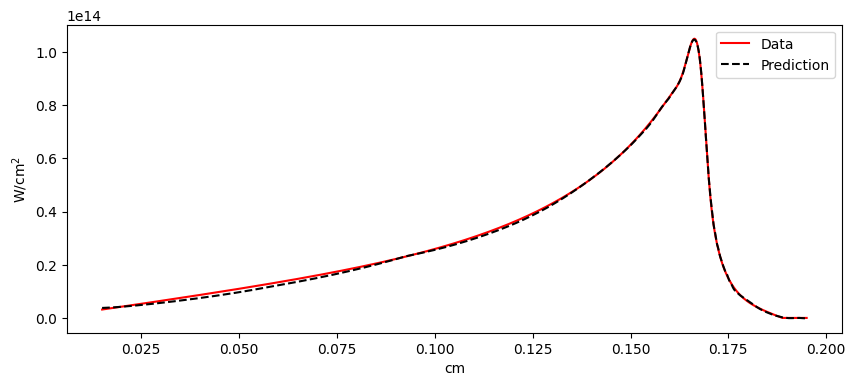

In [15]:
# And finally we can see that our network has done a decent job of estimating!
fig1, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(scaled_Qdata.index,plot_actual, 'r', label='Data')
ax1.plot(scaled_Qdata.index,plot_pred, 'k--', label='Prediction')
ax1.set_xlabel('cm')
ax1.set_ylabel('W/cm$^2$')
ax1.legend()

In [16]:
gradQpred=np.gradient(plot_pred, scaled_Qdata.index)
gradQact=np.gradient(plot_actual, scaled_Qdata.index)

Text(0, 0.5, 'W/cm$^3$')

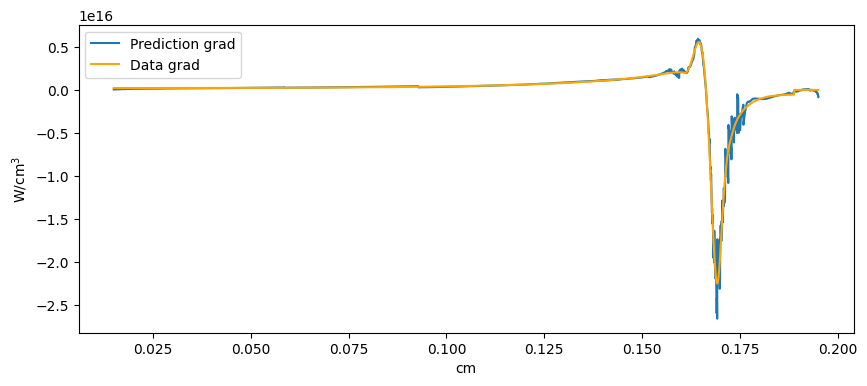

In [17]:
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(scaled_Qdata.index,gradQpred, label='Prediction grad')
ax2.plot(scaled_Qdata.index,gradQact, label='Data grad', color='orange')
ax2.legend()
ax2.set_xlabel('cm')
ax2.set_ylabel('W/cm$^3$')